<a href="https://colab.research.google.com/github/Gh5al/VAT_ITA_classification/blob/data_aug/nlp_pw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [1]:
!pip install nlpaug
!pip install -U deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00


In [2]:
import json
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import torch
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding, AutoModel
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler
import os
import json
import nlpaug.augmenter.word as naw


2025-09-02 17:07:25.075365: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-02 17:07:25.075486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-02 17:07:25.193088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import nltk
nltk.download('wordnet',"/kaggle/working/")
nltk.data.path.append("/kaggle/working/");

[nltk_data] Downloading package wordnet to /kaggle/working/...


In [4]:
device = torch.device('cuda')
GENERATION = False #flag to decide if generate new data with translation + NLPaug
TNAUG = False #augmentation with trans + NLPaug technique for Scheme classification
focal = True #flag for scheme classification to switch loss function from BCE to focal loss
SEED = 27 # Fix the random state for reproducibility (27,42,777)


# Fixing seed

In [5]:
# Fix the random state for reproducibility
def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.

    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

[ ]

fix_seed(SEED)

# Load dataset

In [6]:
def uniform(el):

    """
    Handles the values for multi-value attributes, splitting to list if necessary
    If the input is a list or transformed to a list, values are sorted
    Args:
        el (str or list): The attribute value
    Returns:
        str or list: The attribute value sorted if it is a list, the attribute value otherwise
    """
    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work
        if '|' in el:
            el = sorted(el.split('|'))
        elif isinstance(el, list):
            el = sorted(el)
    return el

DATAFRAMES_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else './Dataframes'

def create_df_annotations(path: str, language: str, dataset: str):

    """
    Load the dataset + create and save to file a dataframe with the annotations of the arguments.

    Args:
        path (str): path of the folder containing the JSON files
        dataset (str): One of [vat, tp, ecj]
    """
    
    pkl_file_path = f"{DATAFRAMES_PATH}/arg_annotations_{language}_{dataset}.pkl.xz"
    if os.path.isfile(pkl_file_path):
        print(f"Found pkl, loading it - {pkl_file_path}")
        return pd.read_pickle(pkl_file_path)
    print(f"Could not find pkl, reading dataset - {pkl_file_path}")
    temp = []
    files = os.listdir(path)
    files.sort()

    for filename in files:
        if not filename.endswith('.json'):
            print(f"Skipping '{filename}'")
        else:
            print(f"Loading '{filename}'")
            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:
                data = json.load(f)
                annotations = data["annotations"]
                last_full_chain_id = None
                last_text = None
                
                for annotation in annotations:
                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':
                        continue # Ignore intro, nreg, judoff, ...

                    #document = annotation["document"]
                    document = data["document"]["name"]
                    name = annotation["name"]
                    _id = annotation["_id"]
                    argument_chain_id = _id[0]
                    full_chain_id = f'{document}_{argument_chain_id}'
                    last_full_chain_id = full_chain_id
                    incremental_num = _id[1:]
                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]
                    last_text = text

                    # attribute extraction, NaN if that attribute is not present
                    T = uniform(annotation["attributes"].get("T", np.nan))
                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))
                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))
                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))
                    INH = uniform(annotation["attributes"].get("INH", np.nan))
                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))
                    S = uniform(annotation["attributes"].get("S", np.nan))
                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')
                    previous = last_text if last_full_chain_id == full_chain_id else None
                    temp.append([
                        document, name, _id, argument_chain_id, incremental_num, text, T, SUP, SFF, ATT, INH, REPH, S, full_chain_id, previous,
                    ])

    # df creation
    df = pd.DataFrame(temp, columns=[
            'Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF', 'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'
        ])
    print(f"Saving {len(df)} annotations to {pkl_file_path}")
    df.to_pickle(pkl_file_path)
    df.to_csv(pkl_file_path.replace('.pkl.xz', '.csv'))
    return df

df = create_df_annotations('Data/Dataset/VAT_ITA', 'italian', 'vat')


Found pkl, loading it - /kaggle/input/nlp-pw/arg_annotations_italian_vat.pkl.xz


In [7]:
df.describe()

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
top,2016_202_VAT_OPAM_2_1_PS_AN,prem,A2,A,2,,F,A2,A7,A8,A10,A1,Rule,2016_202_VAT_OPAM_2_1_PS_AN_A,
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [8]:
df.head(10)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
5,2013_40_VAT_OPAM_2_REM_MB_PS_AN,conc,A6,A,6,"Poiché ciò non è avvenuto, risulta applicabile...",NaN,"[A1, A2, A3]","[A4, A5]",NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"\n Poiché ciò non è avvenuto, risulta appl..."
6,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...
7,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no..."
8,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...
9,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A4,A,4,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...


Example of row with multiple attribute values:

In [9]:
df[df["FullChainID"] == "2021_2717_VAT_OPAM_2_1_FG_PS_AN_A"]

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
3213,2021_2717_VAT_OPAM_2_1_FG_PS_AN,conc,A1,A,1,Passando all'esame del motivo di appello con c...,NaN,A13,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Passando all'esame del motivo di appello con c...
3214,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A2,A,2,"Sul punto, come è noto, giova ricordare che la...",L,NaN,NaN,NaN,NaN,NaN,Princ,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Sul punto, come è noto, giova ricordare che la..."
3215,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A3,A,3,"Con riguardo al primo profilo, dall'esame degl...","[F, L]",NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Con riguardo al primo profilo, dall'esame degl..."
3216,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A4,A,4,Per quanto riguarda il secondo profilo (come r...,F,"[A5, A6]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda il secondo profilo (come r...
3217,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A5,A,5,"Infatti, secondo la corretta interpretazione d...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Infatti, secondo la corretta interpretazione d..."
3218,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A6,A,6,"Ed ancora, le suddette disposizioni vanno inte...",L,NaN,NaN,NaN,NaN,NaN,Prec,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Ed ancora, le suddette disposizioni vanno inte..."
3219,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A7,A,7,"Pertanto, tutti i motivi di appello dell'Uffic...",F,"[A2, A3, A4]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Pertanto, tutti i motivi di appello dell'Uffic..."
3220,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A8,A,8,"Inoltre, nel caso specifico va sottolineato il...",F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Inoltre, nel caso specifico va sottolineato il..."
3221,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A9,A,9,Per quanto riguarda gli ulteriori motivi con i...,F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda gli ulteriori motivi con i...
3222,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A10,A,10,In proposito giova ricordare che l’inesistenza...,"[F, L]",NaN,NaN,NaN,NaN,NaN,"[Prec, Rule]",2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,In proposito giova ricordare che l’inesistenza...


In [10]:
drop_ind=df[df['Text']==''].index
len(drop_ind)
drop_ind

Index([227, 480, 484, 493, 544, 624, 649, 1653, 1700, 1747, 1749, 1786], dtype='int64')

In [11]:
#remove from dataset rows with no text feature
df.drop(drop_ind,inplace=True)

In [12]:
df

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...
3307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...
3308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f..."
3309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...


In [13]:
df.reset_index(drop=True)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...
3295,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...
3296,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f..."
3297,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...


# Preproccesing

## Removing NaN values

Check whether there are any null values for ARGUMENT CLASSIFICATION(AC) task (Name column), and if it's the case then drop them:

In [14]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

Check whether there are any null values for TYPE CLASSIFICATION(TC) task (Type column), and if it's the case then drop them

In [15]:
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True)
df_tc.describe()
df_tc['Type'].drop_duplicates()


0          F
1          L
13    [F, L]
Name: Type, dtype: object

Check whether there are any null values for SCHEME CLASSIFICATION(SC) task (Scheme column), and if it's the case then drop them

In [16]:
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True)
#print(df_sc.describe())
df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1220    [Class, Itpr, Rule]
1237           [Acon, Itpr]
1238          [Class, Tele]
1273     [Prec, Rule, Syst]
1279     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [17]:
#remove excessive white spaces from text column
import re
def remove_whitespace(text):
    t = re.sub(' +', ' ', text)
    return t
df_sc['Text'] =df_sc['Text'].map(remove_whitespace)
df_sc['Text'][1]


"Se il ricorso non è stato proposto da o nei confronti di tutti i soggetti sopra indicati deve essere ordinata l'integrazione del contraddittorio mediante la loro chiamata in causa entro un termine stabilito a pena di decadenza"

In [18]:
df_ac.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3299,3299,3299,3299,3299,3299,2899,1081,81,66,25,88,1311,3299,3299
unique,225,2,264,10,98,3162,3,426,48,32,19,31,63,367,3185
freq,79,2899,221,2341,364,4,1564,54,6,8,3,28,349,79,4


In [19]:
df_tc.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,2899,2899,2899,2899,2899,2899,2899,685,42,66,25,20,1311,2899,2899
unique,225,1,255,10,95,2796,3,297,28,32,19,16,63,367,2811
freq,78,2899,214,2088,346,4,1564,30,4,8,3,2,349,78,4


In [20]:
df_sc.describe().drop('top', axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,1311,1311,1311,1311,1311,1311,1311,271,14,9,14,3,1311,1311,1311
unique,203,1,164,10,62,1240,3,129,11,7,13,3,63,309,1259
freq,41,1311,103,942,174,3,997,15,2,2,2,1,349,41,3


## Argument classification Label Encoder

In [21]:
#df_ac['label'] = df_ac.Name.map({'prem': 0, 'conc': 1})

In [22]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_ac['label'] = le.fit_transform(df_ac['Name'])
le.classes_
le.inverse_transform([0,1])

array(['conc', 'prem'], dtype=object)

In [23]:
df_ac['label'].unique()

array([1, 0])

In [24]:
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

<Axes: >

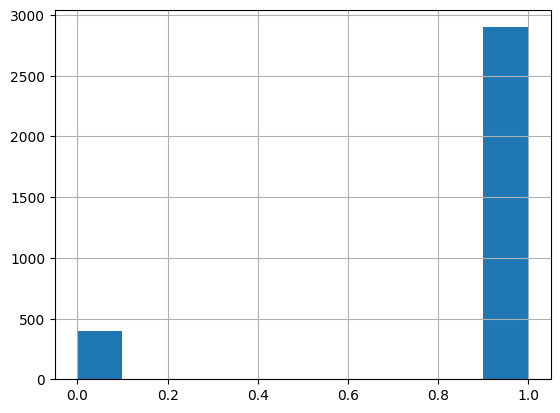

In [25]:
df_ac['label'].hist()

## Type classification multi-label-binarizer

In [26]:
df_tc.loc[13,'Type']

['F', 'L']

In [27]:
#need to extract the values from the list, in a way to pass it to the multilabelbinarizer
for i in range(len(df_tc)):
    x = df_tc.loc[i,'Type']
    if type(x) == list:
        df_tc.loc[i,'Type'] = ",".join([x[0],x[1]])

In [28]:
df_tc.loc[13,'Type']

'F,L'

In [29]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_tc.loc[i,'Type']).split(',') for i in range(len(df_tc))])
df_tc_final = pd.concat([df_tc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_tc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,F,L
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con...",1,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",0,1
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,0,1
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...,1,0
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,0,1
2895,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,0,1
2896,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",0,1
2897,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,0,1


In [30]:
df_tc_labels = df_tc_final[['F','L']]
df_tc_labels

,F,L
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
2894,0,1
2895,0,1
2896,0,1
2897,0,1


## Scheme classification multi-label-binarizer

In [31]:
#need to extract the values from the list, so convert to string, in order to pass them to the multilabelbinarizer

def clean_list(df_sc, column_name):
    for i in range(len(df_sc)):
        x = df_sc.loc[i,column_name]
        if type(x) == list:
            df_sc.loc[i,str(column_name) + "2"] = ",".join(x)
        else:
            try:
                df_sc.loc[i,str(column_name) + "2"] = x
            except:
                print(i,x)
    return df_sc
df_sc = clean_list(df_sc,'Scheme')
df_sc

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,Rule
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [32]:
a = df_sc.explode(['Scheme'])
sc_label_count = a['Scheme'].value_counts()
remove_c = sc_label_count[sc_label_count < 15]
list(remove_c.index)


['Lit', 'Abs', 'Psy', 'Acon']

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_sc.loc[i,'Scheme2']).split(',') for i in range(len(df_sc))])
df_sc_final1 = pd.concat([df_sc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_sc_final1

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [34]:
sc_classes = mlb.classes_
sc_classes

array(['Abs', 'Acon', 'Aut', 'Class', 'Itpr', 'Lit', 'Prec', 'Princ',
       'Psy', 'Rule', 'Syst', 'Tele'], dtype=object)

In [35]:
df_sc_labels = df_sc_final1[mlb.classes_]
df_sc_labels

,Abs,Acon,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1306,0,0,0,0,0,0,0,0,0,1,0,0
1307,0,0,0,0,0,0,0,0,0,1,0,0
1308,0,0,0,0,0,0,0,0,0,1,0,0
1309,0,0,0,1,0,0,0,0,0,1,0,0


In [36]:
#mlb.inverse_transform(np.array(df_sc_labels))

In [37]:
sc_label_count = df_sc_labels.sum().sort_values(ascending=False)
sc_label_count

Rule     573
Prec     417
Itpr     313
Princ    143
Class    100
Aut       72
Syst      28
Tele      18
Lit       12
Abs        8
Psy        7
Acon       1
dtype: int64

<BarContainer object of 12 artists>

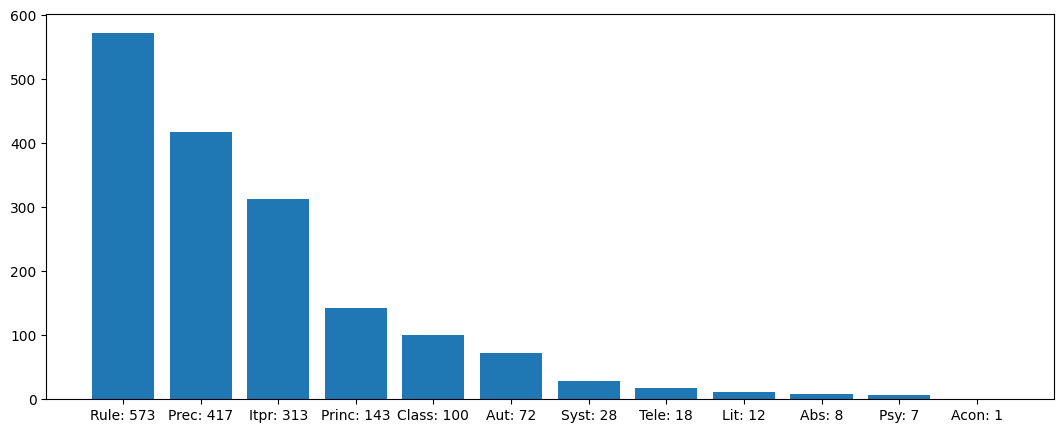

In [38]:
y = np.array(sc_label_count)
#x = np.array(sc_label_count.index)
#added values on x only for convenience
x = [sc_label_count.index[i] + ': ' + str(sc_label_count.iloc[i]) for i in range(len(sc_label_count))]
plt.figure(figsize=(13,5))
plt.bar(x, height=y)

In [39]:
bad_sc_classes = sc_label_count.index[sc_label_count < 15]
sc_classes = sc_label_count.index[sc_label_count >= 15]
print("Removing classes with low number of instances: "+', '.join(bad_sc_classes))
print("Keeping classes with good number of instances: "+', '.join(sc_classes))
good_sc_columns = np.setdiff1d(sc_classes, bad_sc_classes)
print("Remaining columns: "+', '.join(good_sc_columns))
#df_sc_final = df_sc_final1[~df_sc_final1["Scheme2"].isin(bad_sc_classes)].drop(bad_sc_classes,axis=1).reset_index(drop=True)
df_sc_final1

Removing classes with low number of instances: Lit, Abs, Psy, Acon
Keeping classes with good number of instances: Rule, Prec, Itpr, Princ, Class, Aut, Syst, Tele
Remaining columns: Aut, Class, Itpr, Prec, Princ, Rule, Syst, Tele


,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,0,0,1,0,0,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1307,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1308,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
1309,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


In [40]:
#df_sc_final['Scheme'].isin(['Acon'])
#updated version, now we are also considering the list type elements
def remove_bad_classes(df_sc,bad_sc_classes):
    df = df_sc
    for i in range(len(df_sc)):
        x = df.loc[i,'Scheme']
        if type(x) == list:
            for q in x:
                if q in bad_sc_classes:
                    #print(x, q)
                    df = df.drop([i])
                    break
        elif x in bad_sc_classes:
            df = df.drop([i])
    df = df.drop(bad_sc_classes,axis=1).reset_index(drop=True)
    return df
df_r = remove_bad_classes(df_sc_final1,bad_sc_classes)
df_sc_final = df_r
df_sc_final.columns

Index(['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
       'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous', 'Scheme2',
       'Aut', 'Class', 'Itpr', 'Prec', 'Princ', 'Rule', 'Syst', 'Tele'],
      dtype='object')

In [41]:
df_sc_labels

,Abs,Acon,Aut,Class,Itpr,Lit,Prec,Princ,Psy,Rule,Syst,Tele
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1306,0,0,0,0,0,0,0,0,0,1,0,0
1307,0,0,0,0,0,0,0,0,0,1,0,0
1308,0,0,0,0,0,0,0,0,0,1,0,0
1309,0,0,0,1,0,0,0,0,0,1,0,0


In [42]:
df_sc_final1.iloc[384]

Document                            2018_288_VAT_OP_2_0_AP_MB_AN
Name                                                        prem
Id                                                            A7
Chain                                                          A
Num                                                            7
Text           Pertanto, ai fini del riconoscimento della det...
Type                                                           L
SUP                                                     [A8, A9]
SFF                                                          NaN
ATT                                                          NaN
INH                                                          NaN
REPH                                                         NaN
Scheme                                                      Rule
FullChainID                       2018_288_VAT_OP_2_0_AP_MB_AN_A
Previous       Pertanto, ai fini del riconoscimento della det...
Scheme2                  

In [43]:
tr = df_sc_final.explode('Scheme')
#df_sc_final[df_sc_final['Scheme'].explode().isin(['Acon'])]
tr.drop(good_sc_columns,axis=1)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,Scheme2
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,Itpr
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...,Rule
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...,Prec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1280,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,Rule
1281,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",Rule
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Class,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule"


In [44]:
df_sc_labels = df_sc_final[good_sc_columns]
df_sc_labels

,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
1279,0,0,0,0,0,1,0,0
1280,0,0,0,0,0,1,0,0
1281,0,0,0,0,0,1,0,0
1282,0,1,0,0,0,1,0,0


# Data analysis

<Axes: >

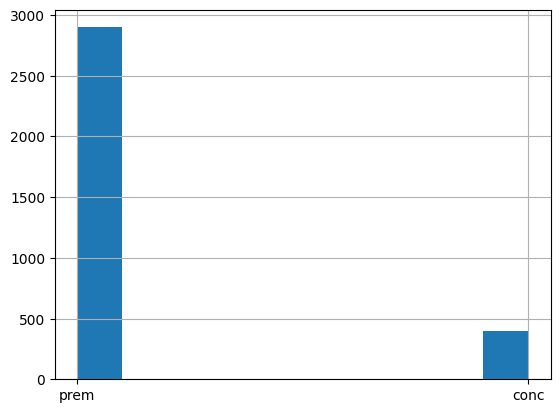

In [45]:
df_ac['Name'].hist()

In [46]:
print(f"There are {len(df_ac[df_ac['Name'] == 'prem'])} premises and {len(df_ac[df_ac['Name'] == 'conc'])} conclusions")

There are 2899 premises and 400 conclusions


<BarContainer object of 2 artists>

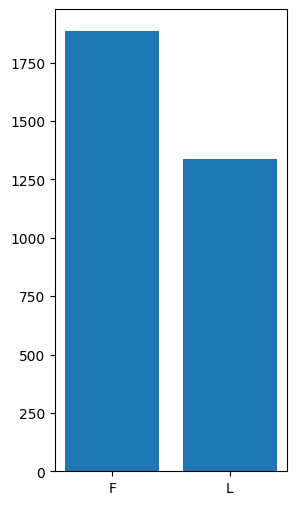

In [47]:
values = df_tc_labels.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)
plt.figure(figsize=(3,6))
plt.bar(x, height=y)

# Utils

## Train-Val-Test dataset splitting

In [48]:
def split_dataset_ac(df, test_size=0.20):
    total_samples = df.shape[0]
    idx_train, idx_test = train_test_split(df['Document'].unique(),
                                      random_state=SEED,
                                      test_size=test_size)
    idx_train, idx_val = train_test_split(idx_train,
                                      random_state=SEED,
                                      test_size=0.10)
    df_train = df[df['Document'].isin(idx_train)]
    df_val = df[df['Document'].isin(idx_val)]
    df_test = df[df['Document'].isin(idx_test)]
    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))
    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))
    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))
    return df_train, df_val, df_test

In [49]:
def split_on_idx(docs_idx,df, test_size=0.20):
    total_samples = df.shape[0]
    idx_train, idx_test = train_test_split(docs_idx,
                                      random_state=SEED,
                                      test_size=test_size)
    idx_train, idx_val = train_test_split(idx_train,
                                      random_state=SEED,
                                      test_size=0.10)
    df_train = df[df['Document'].isin(idx_train)]
    df_val = df[df['Document'].isin(idx_val)]
    df_test = df[df['Document'].isin(idx_test)]
    print('Number of training samples: {} ({}%)'.format(df_train.shape[0], 100*df_train.shape[0]/total_samples))
    print('Number of validation examples: {} ({}%)'.format(df_val.shape[0], 100*df_val.shape[0]/total_samples))
    print('Number of test samples: {} ({}%)'.format(df_test.shape[0], 100*df_test.shape[0]/total_samples))
    return df_train, df_val, df_test

In [50]:
def label_distribution_across_splits(train_df, val_df, test_df, labels):
    distrib = {}
    for label in labels:
        tot = train_df[label].sum() + val_df[label].sum() + test_df[label].sum()
        if tot == 0:
            distrib[label] = {'train': 0, 'val': 0, 'test': 0}
        else:
            distrib[label] = {
                'train': 100 * train_df[label].sum() / tot,
                'val': 100 * val_df[label].sum() / tot,
                'test': 100 * test_df[label].sum() / tot,
            }
    return distrib

In [51]:
labels  = list(df_sc_labels.columns)
def split_dataset_sc(df_sc, show_label_distr = False):
    docs_full  = list(df_sc.Document.unique())
    agg = df_sc.groupby('Document')[labels].sum()
    doc_tele_idx = list(agg.loc[agg.Tele >=1].index)
    doc_syst_idx = list(agg.loc[(agg.Syst >=1) & (agg.Tele <1)].index)
    doc_aut_idx  =  list(agg.loc[(agg.Aut >=1) & (agg.Tele <1) & (agg.Syst<1)].index)
    rare_docs = doc_tele_idx + doc_syst_idx + doc_aut_idx
    first_split_docs_idx =  [d for d in docs_full if d not in rare_docs]
    tr1,val1,test1 = split_on_idx(first_split_docs_idx,df_sc)
    tr2,val2,test2 = split_on_idx(doc_aut_idx,df_sc)
    tr3,val3,test3 = split_on_idx(doc_syst_idx,df_sc)
    tr4,val4,test4 = split_on_idx(doc_tele_idx,df_sc)

    train_df = pd.concat([tr1, tr2, tr3,tr4], axis=0, ignore_index=True)
    val_df = pd.concat([val1, val2, val3, val4], axis=0, ignore_index=True)
    test_df = pd.concat([test1, test2, test3,test4], axis=0, ignore_index=True)

    if show_label_distr:
        distrib = label_distribution_across_splits(train_df, val_df, test_df, labels)

        for label, perc in distrib.items():
            print(f"Distribuzione label '{label}':")
            print(f"  Train: {perc['train']:.2f}%")
            print(f"  Val:   {perc['val']:.2f}%")
            print(f"  Test:  {perc['test']:.2f}%\n")
            
    return train_df,val_df,test_df
 

In [52]:
tr,val,ts = split_dataset_sc(df_sc_final)

Number of training samples: 485 (37.77258566978193%)
Number of validation examples: 93 (7.242990654205608%)
Number of test samples: 125 (9.735202492211839%)
Number of training samples: 183 (14.25233644859813%)
Number of validation examples: 32 (2.4922118380062304%)
Number of test samples: 66 (5.140186915887851%)
Number of training samples: 99 (7.710280373831775%)
Number of validation examples: 16 (1.2461059190031152%)
Number of test samples: 15 (1.1682242990654206%)
Number of training samples: 118 (9.190031152647975%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 43 (3.3489096573208723%)


In [53]:

tr, val, ts = split_dataset_ac(df_sc_final)


distrib = label_distribution_across_splits(tr, val, ts, labels)

for label, perc in distrib.items():
    print(f"Distribuzione label '{label}':")
    print(f"  Train: {perc['train']:.2f}%")
    print(f"  Val:   {perc['val']:.2f}%")
    print(f"  Test:  {perc['test']:.2f}%\n")

Number of training samples: 899 (70.01557632398755%)
Number of validation examples: 133 (10.358255451713395%)
Number of test samples: 252 (19.626168224299064%)
Distribuzione label 'Aut':
  Train: 66.67%
  Val:   11.11%
  Test:  22.22%

Distribuzione label 'Class':
  Train: 68.00%
  Val:   6.00%
  Test:  26.00%

Distribuzione label 'Itpr':
  Train: 65.37%
  Val:   10.03%
  Test:  24.60%

Distribuzione label 'Prec':
  Train: 73.61%
  Val:   9.93%
  Test:  16.46%

Distribuzione label 'Princ':
  Train: 73.94%
  Val:   9.15%
  Test:  16.90%

Distribuzione label 'Rule':
  Train: 70.77%
  Val:   10.74%
  Test:  18.49%

Distribuzione label 'Syst':
  Train: 66.67%
  Val:   14.81%
  Test:  18.52%

Distribuzione label 'Tele':
  Train: 58.82%
  Val:   29.41%
  Test:  11.76%



In [54]:
from skmultilearn.model_selection import iterative_train_test_split
def iterative_split(df_sc_final, df_sc_labels,test_size=0.15):
    X = np.expand_dims(df_sc_final.index.values,1)
    y = df_sc_labels.values
    t_train, y_train, t_test, y_test = iterative_train_test_split(X,y, test_size = 0.2)
    t_train, y_train, t_val, y_val = iterative_train_test_split(t_train, y_train, test_size = 0.15)
    print(np.shape(t_train),np.shape(t_test),np.shape(t_val))
    df_train = df_sc_final.iloc[np.squeeze(t_train)]
    df_val = df_sc_final.iloc[np.squeeze(t_val)]
    df_test = df_sc_final.iloc[np.squeeze(t_test)]
    return df_train,df_val,df_test


In [55]:
#df_train,df_val,df_test = iterative_split(df_sc_final,df_sc_labels)
df_train,df_val,df_test = split_dataset_sc(df_sc_final)


Number of training samples: 485 (37.77258566978193%)
Number of validation examples: 93 (7.242990654205608%)
Number of test samples: 125 (9.735202492211839%)
Number of training samples: 183 (14.25233644859813%)
Number of validation examples: 32 (2.4922118380062304%)
Number of test samples: 66 (5.140186915887851%)
Number of training samples: 99 (7.710280373831775%)
Number of validation examples: 16 (1.2461059190031152%)
Number of test samples: 15 (1.1682242990654206%)
Number of training samples: 118 (9.190031152647975%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 43 (3.3489096573208723%)


In [56]:
df_train['Scheme'].explode().value_counts()

Scheme
Rule     385
Prec     292
Itpr     226
Princ     92
Class     64
Aut       55
Syst      17
Tele      11
Name: count, dtype: int64

In [57]:
df_val['Scheme'].explode().value_counts()
df_test['Scheme'].explode().value_counts()

Scheme
Rule     126
Prec      76
Itpr      52
Class     25
Princ     18
Aut       12
Syst       6
Tele       4
Name: count, dtype: int64

In [58]:
#df_train, df_val, df_test=split_dataset(df_sc_final)
df_train1  = df_train.explode('Scheme')
df_train1[df_train1['Scheme2']=='Tele']['Text']

817    I cosiddetti “premi di incentivazione' sono fi...
862    Dall'esame degli atti emerge che la società BM...
870    La ratio, è evidente, è quella di evitare che ...
Name: Text, dtype: object

In [59]:
df_train1['Scheme'].value_counts()

Scheme
Rule     385
Prec     292
Itpr     226
Princ     92
Class     64
Aut       55
Syst      17
Tele      11
Name: count, dtype: int64

In [60]:
count = df_sc_labels.sum().sort_values(ascending=False)
tot=np.array(count.reset_index(drop=True)).sum()
inv_class_fq = count/tot
1/inv_class_fq
class_weights = tot / (count)
class_weights

Rule      2.901408
Prec      3.990315
Itpr      5.333333
Princ    11.605634
Class    16.480000
Aut      22.888889
Syst     61.037037
Tele     96.941176
dtype: float64

## Data Aug with translation + NLPaug

In [61]:
if GENERATION:
    from deep_translator import GoogleTranslator,ChatGptTranslator,PonsTranslator
    #GoogleTranslator(source='auto', target='en').translate("guten Tag")
    translator = GoogleTranslator(source = 'italian',target = 'english')
    retranslator =  GoogleTranslator(source = 'english',target = 'italian')
    #tried also with roberta-large and insertion, but this performed slightly better
    aug = naw.ContextualWordEmbsAug(
    model_path='bert-large-cased', action="substitute")


In [62]:
def google_translate(text,translator):
    output = []
    #print(translate_text)
    for t in text:
        translate_text = translator.translate(t)
        output.append(translate_text)
    return output
def google_retranslate(text,translator):
    output = []
    #print(translate_text)
    for t in text:
        translate_text = translator.translate(t)
        output.append(translate_text)
    return output

def augment(aug,text,n=1):
    aug_text = aug.augment(text,n=n)
    #print(f"aug: {aug_text}")
    return aug_text

def translate(model,tokenizer,text):
    model.eval()
    translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True),max_length=256,)
    trans_text = []

    for t in translated:
        z = tokenizer.decode(t, skip_special_tokens=True)
        #print(z)
        trans_text.append(z)
    return trans_text

def retranslate(model,tokenizer,text):
    model.eval()
    retranslated = model.generate(**tokenizer(text, return_tensors="pt", padding=True),max_length=256)
    retrans_text = []
    for t in retranslated:
        z = tokenizer.decode(t, skip_special_tokens=True)
        #print(z)
        retrans_text.append(z)
    return retrans_text


In [63]:
#maj_classes  = ['Rule','Prec','Itpr']
#no maj classes
#df_to_aug = df_train[~df_train[maj_classes].any(axis=1)].reset_index(drop=True)

In [64]:
df_to_aug=df_train

In [65]:
if GENERATION:
    new_text = []
    new_target = []

    #start with the class having the smallest suppport
    class_to_aug = ['Tele','Syst','Aut','Class','Princ']
    
    #n_samples = [1,2,3,5,6]
    n_samples = [6,5,4,3,1]
    visited = [] #avoid augmenting same sentence belonging to two or more classes 
    
    for ca,n in zip(class_to_aug,n_samples):

        new_df = df_to_aug[df_to_aug[ca]== 1]
        print(ca)
        for i in new_df.index:
            if i in visited:
                continue
            x = df_to_aug.iloc[i]
            text = x.Text
            a = google_translate([text],translator)
            #print(a)
            b = augment(aug,a[0],n=n)
            #print(b)
            c = google_retranslate(b,retranslator)
            new_text = new_text + c
            #print(list(x[labels].values))
            values  = list(x[labels].values)
            new_target = new_target + [values]*n
            visited.append(i)
        print(len(new_text))
        #print(new_target)
    new_df = pd.DataFrame(new_target,columns = labels)
    new_df.insert(0,'Text',new_text)
    new_df.to_csv(f'aug_data_{SEED}.csv')

In [66]:
def load_aug_data(df_train):
    AUG_PATH = '/kaggle/input/nlp-pw' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else os.getcwd()
    #AUG_PATH = os.getcwd()
    new_dataframe = pd.read_csv("".join([AUG_PATH,f'/aug_data_{SEED}.csv']))
    new_dataframe=new_dataframe.drop('Unnamed: 0',axis=1)
    df1 = df_train[['Text',*labels]].reset_index(drop=True)
    tot_df = pd.concat([df1,new_dataframe],ignore_index=True)
    return tot_df    

In [67]:
merge_df = load_aug_data(df_train)
merge_df

,Text,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",0,0,0,0,0,1,0,0
1,Se il ricorso non è stato proposto da o nei co...,0,0,1,0,0,0,0,0
2,Secondo condivisa e costante giurisprudenza (C...,0,0,0,0,0,1,0,0
3,"Tuttavia, nel caso qui in esame, la Comm/ne no...",0,0,1,0,0,0,0,0
4,A tal proposito si ricorda che la Corte cost. ...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1498,Ma un'IVA per gli immigrati è un diritto comme...,0,0,0,0,1,0,0,0
1499,Il fornitore ha dovuto inviare protocollo le d...,0,0,0,0,1,0,0,0
1500,Deve quindi sembrare che il solito cliente / e...,0,0,0,0,1,0,0,0
1501,"Né, infine, se gli effetti dell'incapacità di ...",0,0,0,0,1,1,0,0


In [68]:
merge_df[[*labels]].sum(axis=0)

Aut      275
Class    264
Itpr     325
Prec     421
Princ    207
Rule     548
Syst     104
Tele      77
dtype: int64

## Save and load results

The results folder will contain the notebook, metrics and outputs for each seed.

In [69]:
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)



def results_to_csv(df_results, seed):

    '''
    Args:
        df_results: DataFrame with the all the scores
        seed: the used seed

    '''
    csv_path = f"{results_folder}/{seed}.csv"
    df_results.to_csv(path_or_buf=csv_path)

In [70]:
def results_from_csv(seed):
    '''
    Args:
        seed: the wanted seed

    '''
    file_path = f"results/{seed}.csv"
    df_results = pd.read_csv(file_path)
    return df_results

## PyTorch dataset

In [71]:
class CustomTorchDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

## Focal Loss

In [72]:
num_label=len(good_sc_columns)

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, logit=False, reduce=False):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logit = logit
        self.reduce = reduce

    def forward(self, inputs, targets):
        """
        BCE = nn.BCELoss()
        BCE_loss = BCE(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        """
        #p = torch.where(targets >= 0.5, inputs, 1-inputs)
        p = inputs * targets + (1 - inputs) * (1 - targets)
        if self.alpha != None:
            weight_mask = torch.where(targets >= 0.5, self.alpha, 1)
        logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
        #loss = logp*((1-p)**self.gamma)
        #print(f"wo_weight:{loss}")
        if self.alpha != None:
            loss = self.alpha*logp*((1-p)**self.gamma)
        else:
            loss = logp*((1-p)**self.gamma)
        #print(f"w_weight:{loss}")
        loss = loss.mean()
        return loss

# Processing

## Encoding

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import stopwords


class BaselineVectorizer():

    def __init__(self, include_previous=False, max_features=None):
        self.tfidf = TfidfVectorizer(stop_words=stopwords.words('italian'),max_features=max_features)
        self.include_previous = include_previous
        self.fitted = False



    def _clean_texts(self,df):
        texts = df["Previous"]+". "+df["Text"] if INCLUDE_PREVIOUS else df["Text"]
        cleaned = []
        for text in texts:
            text = re.sub("[^a-zA-Z0-9]"," ",text).lower().strip()
            cleaned.append(text)
        return cleaned

    def fit(self,df):
        cleaned_texts = self._clean_texts(df)
        self.tfidf.fit(cleaned_texts)
        self.fitted = True

    def transform(self,df):
        if not self.fitted:
            raise Exception("Vectorizer is not fitted.")
        cleaned_texts = self._clean_texts(df)
        return self.tfidf.transform(cleaned_texts)

In [74]:
def encode(tokenizer:PreTrainedTokenizer,
           df:pd.DataFrame,
           labels,
           scheme=False,
           include_previous=False):

    '''
    Encodes the dataset according to the BERT specifications.
    The method encodes the data in the following way:
        [CLS] previous [SEP] current [SEP]
        where -previous- is the previous (if any) sentence in the same argumentation chain
        and -current- is the current sentence
    '''
    print("Encoding...")
    encodings = tokenizer(
          list(df['Previous']), list(df['Text']), padding=True, truncation=True, max_length = 512
        ) if include_previous else tokenizer(
          list(df['Text']), padding=True, truncation=True, max_length = 512
        )

    input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
    print(f"input shape: {np.shape(input_ids)}")
    if not scheme:
        encodings.update({'labels' : torch.LongTensor(labels.values)})
    else:
        encodings.update({'labels': torch.FloatTensor(labels.values)})
    encodings.pop('token_type_ids')
    print("Encoding complete")
    return encodings

## Model

In [75]:
class ACModel(nn.Module):

    def __init__(self,checkpoint, output_size):
        super(ACModel, self).__init__()
        self.model = AutoModel.from_pretrained(checkpoint)
        self.output_size = output_size
        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(self.model.config.hidden_size, self.output_size)

    def forward(self, input_ids, attention_mask,only_embeddings=False):
        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        pooler_output = output.pooler_output
        x = self.cl1(pooler_output)
        x = self.relu(x)
        x = self.output(x)
        if only_embeddings:
            return pooler_output
        else:
            return x

class SCModel(nn.Module):

    def __init__(self,checkpoint, output_size):

        super(SCModel, self).__init__()

        self.model = AutoModel.from_pretrained(checkpoint)

        self.output_size = output_size
        self.cl1 = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        #self.tanh = nn.Tanh()
        self.classifier = nn.Linear(self.model.config.hidden_size, self.output_size)


    def forward(self, input_ids, attention_mask,only_embeddings=False, freeze=None, x_aug=None):

        output  = self.model(input_ids, attention_mask=attention_mask, output_hidden_states=True)

        pooler_output = output.pooler_output
        x = self.dropout(pooler_output)
        x = self.cl1(x)
        x = self.relu(x)
        #x = self.tanh(x)
        #x = self.cl2(x)
        #x = self.relu(x)
        #x  = self.cl3(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)

        if only_embeddings:
            return pooler_output
        else:
            return x



In [76]:
def getModel(model_checkpoint, num_labels, scheme=False,only_embeddings = False):

    '''
    Creates and return an instance of the desired model with the correct tokenizer.
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
    if scheme:
        model = SCModel(model_checkpoint, num_labels)
    else:
        model = ACModel(model_checkpoint, num_labels)
    return model, tokenizer

## Train

In [77]:
# Train one epoch
def train_epoch(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: torch.nn.Module,
          epoch: int) -> float:

    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        epoch: the number of the current epoch.
    Returns:
        the cross entropy Loss value on the training data.

    """
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids,
                     attention_mask=attention_mask,
                        )
        loss = criterion(logits, labels)
        #loss = focal_loss(logits,labels)
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train



# Validate one epoch
def validate(model: torch.nn.Module,
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device,
             val_labels,
             compute_f1 = False) -> float:

    """
    Evaluates the model.
    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    predictions = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            #f_loss = FocalLoss(gamma=0)
            #loss = f_loss(logits,labels)
            loss = criterion(logits, labels)
            #loss = focal_loss(logits,labels)
            loss_score.append(loss.item())
            predictions.append(logits.cpu().detach().numpy())
    predictions = np.concatenate(predictions)
    if compute_f1:
        y_pred = np.where(predictions<0.5,0.,1.)
        y_true = np.array(val_labels)
        score = f1_score(y_true,y_pred,average='macro')
        print(f"f1_macro_score: {score}")
    else:
        score = None
    loss_val = np.mean(loss_score)
    return loss_val, score

In [78]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim,
                  criterion: torch.nn.Module,
                  model: torch.nn.Module,
                  lr: float,
                  loader_train: torch.utils.data.DataLoader,
                  loader_val : torch.utils.data.DataLoader = None,
                  val_labels=None,
                  model_dir = "models",
                  verbose: bool=True,
                  compute_f1 = False,
                  use_cuda = False) -> Dict:

    """Executes the training loop.
        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            criterion: criterions used to calculate loss.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            model_dir: checkpoints folder.
            verbose: if true print the value of loss.
        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.

    """
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []
    #best_epoch = 1
    #val_cri = nn.BCELoss(reduction = 'mean')
    val_cri = criterion
    #cri = DiceLoss()
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        #if epoch > 3:
            #criterion = cri
        loss_train = train_epoch(model, loader_train, device,
                                           optimizer, criterion, epoch)
        if(loader_val != None):
            loss_val,score = validate(model, val_cri, loader_val, device,val_labels,compute_f1)
            #val_predictions = evaluate(model, loader_val)
            #print(np.array(val_predictions).shape)
            #y_pred = np.where(val_predictions<0.5, 0., 1.)
            #y_true = np.array(val_labels)
            #print(y_true.shape, y_pred.shape)
            #print("\n"+classification_report(y_true, y_pred,target_names = sc_classes))
        else:
            loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)
       # torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
       # best_epoch = np.argmin(val_losses_values)+1
        if verbose and score:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} '
                  f' f1_score: {score:.4f} '
                )
        elif verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} '
                )
        """
        if epoch >= 5:
            if loss_val > val_losses_values[-2] and loss_val> val_losses_values[-1]  :
                if verbose:
                    print("Early Stopping. Best epoch: {}".format(best_epoch))
                break

        """
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')
    #model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(best_epoch))))
    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

In [79]:
def execute(lr: float,
            num_epochs: int,
            batch_size: int,
            num_labels: int,
            train_df: pd.DataFrame,
            train_labels: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels: pd.DataFrame,
            scheme = True,
            focal = False,
            model_name="",
            model=None,
            tokenizer=None,
            use_cuda=True,
            include_previous=False,
            compute_f1=False,
            sampler: torch.utils.data.Sampler = None,
            cwt = None
            ) ->Tuple[torch.nn.Module, any]:

    """Gets the model, does the encodings of the training and validation data using the
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        train_df: training-val dataframe.
        train_labels: training-val labels dataframe.
        val_df: validation dataframe.
        val_labels: val labels dataframe.
        scheme: boolean flag to switch between task.
        focal:
        model_name
        model: the network to train.
        model
        tokenizer
        use_cuda
        include_previous
        sampler
        cwd
    """

    #train on full data

    #get the model and the tokenizer

    if not model_name == "":
        model, tokenizer = getModel(model_name, num_labels, scheme)
    if scheme:
        if focal:
            criterion = FocalLoss(alpha=cwt)
        else:
            criterion = torch.nn.BCELoss()
    else:
        criterion = torch.nn.CrossEntropyLoss()
    #Start encodings
    #print(f'Train set:')
    train_encodings = encode(tokenizer, train_df, train_labels, scheme, include_previous=include_previous)
    val_encodings = encode(tokenizer, val_df, val_labels, scheme, include_previous=include_previous)
    print(f'ENCODING COMPLETE.')
    #create training dataset
    train_dataset = CustomTorchDataset(train_encodings)
    #create training dataloader
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = sampler is None,
                                        sampler = sampler )
    #create validation dataset
    val_dataset = CustomTorchDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False) # No custom sampling in validation
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    #optimizer = Adafactor(model.parameters(), lr = 5e-5)
    print(f'STARTING TRAINING with complete data:')
    model_dir = 'model_data'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    statistics = training_loop(num_epochs, optimizer, criterion, model,lr,
                              data_loader_train, data_loader_val,val_labels,
                               model_dir=model_dir, compute_f1=compute_f1,use_cuda=use_cuda)
    print(f'TRAINING COMPLETE.')
    return model, tokenizer, statistics

In [80]:
from sklearn.svm import SVC, LinearSVC
from sklearn.multiclass import OneVsRestClassifier

def executeTfIdfSvm(train_df: pd.DataFrame,
                    train_labels,
            test_df: pd.DataFrame,
                    test_labels,
            class_names,
            kernel = "linear",
            scheme = False,
            include_previous = False,
            weighted_sampling = False):

    # Build tokenizer
    tokenizer = BaselineVectorizer(include_previous=include_previous)
    tokenizer.fit(train_df)

    # Build model
    if scheme:
        # https://scikit-learn.org/stable/modules/svm.html#multi-class-classification
        # https://scikit-learn.org/stable/modules/multiclass.html
        model = OneVsRestClassifier(LinearSVC(random_state=SEED)) if kernel=="linear" else OneVsRestClassifier(SVC(kernel=kernel, random_state=SEED))
    else:
        # https://scikit-learn.org/stable/modules/svm.html#classification
        model = LinearSVC(random_state=SEED) if kernel=="linear" else SVC(kernel=kernel, random_state=SEED)
    #class_column = 'Scheme' if scheme else 'Name' # TODO is Name correct for AC?
    df_train_sample_weights = [class_weights[i] for i in df_train[class_column]] if weighted_sampling else None

    # Train model
    train_encodings = tokenizer.transform(train_df)
    #labels = train_df['Scheme'] if scheme else train_df['label']
    model.fit(train_encodings,train_labels)

    # Test model
    test_encodings = tokenizer.transform(test_df)
    #test_labels = test_df['Scheme'] if scheme else test_df['label']
    y_pred = model.predict(test_encodings)
    print("\n Baseline kernel: "+kernel+"\n"+classification_report(test_labels, y_pred,target_names = class_names))
    return model, tokenizer

In [81]:
df_train['Scheme']

0              Rule
1              Itpr
2              Rule
3              Itpr
4              Prec
           ...     
880     [Aut, Prec]
881             Aut
882            Rule
883            Rule
884    [Itpr, Rule]
Name: Scheme, Length: 885, dtype: object

# Execution configuration

In [82]:
#legal bert outperforms the other two models

#model_checkpoint = 'dbmdz/bert-base-italian-xxl-cased' # https://huggingface.co/dbmdz/bert-base-italian-xxl-cased
model_checkpoint = "dhfbk/gulbert-ft-ita"
model_checkpoint = "dbmdz/bert-base-italian-xxl-uncased"
model_checkpoint = "dlicari/Italian-Legal-BERT" # https://huggingface.co/dlicari/Italian-Legal-BERT
False
#parameters
lr = 5e-5
batch_size = 32
epochs = 8
USE_CUDA = True
INCLUDE_PREVIOUS=False
ABBREVIATION_AUGMENTATION = False # whether to do data augmentation expanding abbreviations
WEIGHTED_SAMPLING=False
AUG = False
focal = False #use focal loss instead of crossentropy

In [83]:
df_sc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,...,Previous,Scheme2,Aut,Class,Itpr,Prec,Princ,Rule,Syst,Tele
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,...,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",Rule,0,0,0,0,0,1,0,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei co...,L,NaN,NaN,NaN,...,Se il ricorso non è stato\n proposto da o ...,Itpr,0,0,1,0,0,0,0,0
2,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,...,Secondo condivisa e costante giurisprudenza (C...,Rule,0,0,0,0,0,1,0,0
3,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,...,"Tuttavia, nel caso qui in esame, la Comm/ne no...",Itpr,0,0,1,0,0,0,0,0
4,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,...,A tal proposito si ricorda che la Corte cost. ...,Prec,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,...,Sotto questo profilo i Compro Oro sono sottopo...,Rule,0,0,0,0,0,1,0,0
1280,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,...,Tale comunicazione ha luogo quando i destinata...,Rule,0,0,0,0,0,1,0,0
1281,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,...,"Il Ministro dell'interno, con decreto del 17 f...",Rule,0,0,0,0,0,1,0,0
1282,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,...,Tra i soggetti destinatari del decreto sono ri...,"Class,Rule",0,1,0,0,0,1,0,0


In [84]:
abbr_file_path = ('/kaggle/input' if os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') else '.')+"/abbreviazioni.tsv"
if ABBREVIATION_AUGMENTATION and os.path.isfile(abbr_file_path):
    print(f"Augmenting {len(df_train)} training annotations with abbreviations")
    abbreviations_df = pd.read_csv(abbr_file_path, sep='\t', header=None, names=['Meaning','Abbreviation'])
    print(f"Loaded {len(abbreviations_df)} abbreviations")
    long_df = df_train.copy()
    for i, abbr_row in abbreviations_df.iterrows():
        abbr_regex = "(?i)\\b"+(abbr_row['Abbreviation'].replace('.','\.')) # https://stackoverflow.com/a/54464222/2347196
        long_df["Text"] = long_df["Text"].str.replace(abbr_regex, abbr_row['Meaning'], regex=True)
        long_df["Previous"] = long_df["Previous"].str.replace(abbr_regex, abbr_row['Meaning'], regex=True)
    df_train = pd.concat([df_train, long_df], ignore_index=True)
    print(f"{len(df_train)} annotations are now available")
else:
    print("Skipping abbreviation data augmentation")

Skipping abbreviation data augmentation


### Evaluate

In [85]:
def evaluate(model, data_loader, use_cuda=True):
    predictions = []
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    loop = tqdm(data_loader)
    with torch.no_grad():
        for batch in loop:
            pred = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
            pred = pred.cpu().detach().numpy()
            predictions.append(pred)
    predictions = np.concatenate(predictions)
    return predictions

In [86]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# ARGUMENTATIVE CLASSIFICATION

In [87]:
df_train, df_val, df_test = split_dataset_ac(df_ac)
num_labels = len(df_train['label'].unique())
train_labels = df_train['label']
val_labels = df_val['label']
test_labels = df_test['label']
class_names = le.classes_

Number of training samples: 2463 (74.65898757199152%)
Number of validation examples: 246 (7.456805092452258%)
Number of test samples: 590 (17.88420733555623%)


## Baseline: TF-IDF + SVM

In [88]:
from sklearn.metrics import classification_report,f1_score
#base_model, base_tokenizer = executeTfIdfSvm(
#use only linear kernel
for kernel in ['linear']:
    executeTfIdfSvm(
        df_train,
        train_labels,
        df_test,
        test_labels,
        class_names,
        kernel = kernel,
        scheme = False,
        include_previous=False,
        weighted_sampling = WEIGHTED_SAMPLING
    )


 Baseline kernel: linear
              precision    recall  f1-score   support

        conc       0.88      0.66      0.75        79
        prem       0.95      0.99      0.97       511

    accuracy                           0.94       590
   macro avg       0.92      0.82      0.86       590
weighted avg       0.94      0.94      0.94       590



## Training

In [89]:
from sklearn.metrics import classification_report,f1_score
epochs = 8
model, tokenizer, statistics = execute(

    lr,
    epochs,
    batch_size,
    num_labels,
    df_train,
    train_labels,
    df_val,
    val_labels,
    scheme=False,
    focal=focal, #BCE or FOCAL LOSS
    model_name=model_checkpoint,
    use_cuda=USE_CUDA,
    include_previous=False,
)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dlicari/Italian-Legal-BERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding...
input shape: (2463, 391)
Encoding complete
Encoding...
input shape: (246, 330)
Encoding complete
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/77 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 77/77 [01:41<00:00,  1.32s/it, loss=0.121]


Epoch: 1  Lr: 0.00005000  Loss: Train = [0.1972] - Val = [0.1557]  Time one epoch (s): 103.9009 


Epoch 2: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.0944]


Epoch: 2  Lr: 0.00005000  Loss: Train = [0.0929] - Val = [0.1727]  Time one epoch (s): 103.0319 


Epoch 3: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.0458]


Epoch: 3  Lr: 0.00005000  Loss: Train = [0.0532] - Val = [0.1635]  Time one epoch (s): 102.9838 


Epoch 4: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.0282]


Epoch: 4  Lr: 0.00005000  Loss: Train = [0.0209] - Val = [0.1827]  Time one epoch (s): 102.9461 


Epoch 5: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.00234]


Epoch: 5  Lr: 0.00005000  Loss: Train = [0.0160] - Val = [0.2018]  Time one epoch (s): 102.9671 


Epoch 6: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.359]


Epoch: 6  Lr: 0.00005000  Loss: Train = [0.1517] - Val = [1.4145]  Time one epoch (s): 102.9129 


Epoch 7: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.383]


Epoch: 7  Lr: 0.00005000  Loss: Train = [0.2941] - Val = [0.4345]  Time one epoch (s): 102.9296 


Epoch 8: 100%|██████████| 77/77 [01:40<00:00,  1.30s/it, loss=0.253]


Epoch: 8  Lr: 0.00005000  Loss: Train = [0.2847] - Val = [0.4293]  Time one epoch (s): 102.9727 
Time for 8 epochs (s): 824.646
TRAINING COMPLETE.


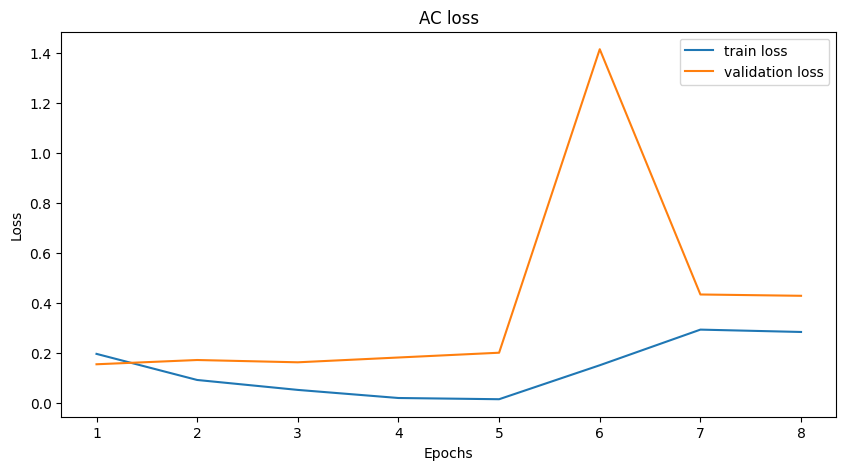

In [90]:
scheme = False
plt.figure(figsize=(10,5))
plt.title("SC loss" if scheme else "AC loss")
plt.plot(statistics['train_loss_values'],label="train loss")
plt.plot(statistics['val_loss_values'],label="validation loss")
plt.xlabel("Epochs")
plt.xticks(np.arange(epochs), np.arange(1, epochs+1, 1))
plt.ylabel("Loss")
plt.legend()
plt.show()

## AC Evaluation

In [91]:
def predict(model, data_loader, use_cuda=True):

    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for step_num, batch in tqdm(enumerate(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            #labels_emo = batch['labels'].to(device)
            output = model(input_ids, attention_mask=attention_mask)
            pred= output
            pred = pred.cpu().detach().numpy()
            predictions.append(np.argmax(pred,axis=-1))
    predictions = np.concatenate(predictions)
    return predictions

In [92]:
#base_test_encodings = base_tokenizer.transform(df_test)
train_encodings = encode(tokenizer, df_train, train_labels)
val_encodings = encode(tokenizer, df_val, val_labels)
test_encodings = encode(tokenizer,df_test,test_labels)
print(f'ENCODING COMPLETE.')

Encoding...
input shape: (2463, 391)
Encoding complete
Encoding...
input shape: (246, 330)
Encoding complete
Encoding...
input shape: (590, 410)
Encoding complete
ENCODING COMPLETE.


In [93]:

#create val dataset
val_dataset = CustomTorchDataset(val_encodings)
#create val dataloader
data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                  batch_size=batch_size,
                                  shuffle = False)
y_true = val_labels
y_pred = predict(model,data_loader_val)
print('/n'+""+classification_report(y_true, y_pred))

0it [00:00, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
8it [00:02,  3.15it/s]

/n              precision    recall  f1-score   support

           0       0.46      0.42      0.44        38
           1       0.90      0.91      0.90       208

    accuracy                           0.83       246
   macro avg       0.68      0.66      0.67       246
weighted avg       0.83      0.83      0.83       246



In [94]:
y_true = test_labels
#y_pred = base_model.predict(base_test_encodings)
#print("\n Baseline: \n"+classification_report(y_true, y_pred))
#create test dataset
test_dataset = CustomTorchDataset(test_encodings)
#create test dataloader
data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                  batch_size=batch_size,
                                  shuffle = False)
y_pred = predict(model,data_loader_test)
print("\n Actual model: \n"+classification_report(y_true, y_pred))

0it [00:00, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
19it [00:07,  2.38it/s]


 Actual model: 
              precision    recall  f1-score   support

           0       0.47      0.43      0.45        79
           1       0.91      0.93      0.92       511

    accuracy                           0.86       590
   macro avg       0.69      0.68      0.68       590
weighted avg       0.85      0.86      0.86       590



In [95]:
#score = f1_score(y_true, y_pred, labels=df_test['label'].unique(), average='macro')

# SCHEME CLASSIFICATION

## Settings

In [96]:
df_train, df_val, df_test = split_dataset_sc(df_sc_final)
print("Scheme task")
train_labels = df_train[sc_classes]
val_labels = df_val[sc_classes]
test_labels = df_test[sc_classes]
num_labels = train_labels.shape[1]

#compute class weights to be used in focal loss
count = df_train['Scheme'].explode().value_counts()
tot = df_train['Scheme'].explode().value_counts().sum()
if TNAUG:
    df_train = load_aug_data(df_train)
    train_labels = df_train[sc_classes]
    count = df_train[[*sc_classes]].sum(axis=0)
    tot = df_train[[*sc_classes]].sum(axis=0).sum()
cwt = class_weights = tot/count
class_weights = np.log(class_weights)
class_weights = class_weights / np.min(class_weights)
cw = class_weights.reset_index(drop=True).to_frame()
cwt = torch.stack(list(map(lambda x : torch.tensor(x,device=device,dtype = torch.float32),np.array(cw).squeeze())))
class_names = list(sc_classes)
print(cwt)
class_names

Number of training samples: 485 (37.77258566978193%)
Number of validation examples: 93 (7.242990654205608%)
Number of test samples: 125 (9.735202492211839%)
Number of training samples: 183 (14.25233644859813%)
Number of validation examples: 32 (2.4922118380062304%)
Number of test samples: 66 (5.140186915887851%)
Number of training samples: 99 (7.710280373831775%)
Number of validation examples: 16 (1.2461059190031152%)
Number of test samples: 15 (1.1682242990654206%)
Number of training samples: 118 (9.190031152647975%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 43 (3.3489096573208723%)
Scheme task
tensor([1.0000, 1.2543, 1.4899, 2.3165, 2.6503, 2.7897, 3.8695, 4.2699],
       device='cuda:0')


['Rule', 'Prec', 'Itpr', 'Princ', 'Class', 'Aut', 'Syst', 'Tele']

In [97]:
# https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452

# https://gist.github.com/Chris-hughes10/260c70650c5a6f322d273a8a8728b91a

if WEIGHTED_SAMPLING:
    class_weights_arr = [class_weights[i] for i in sc_label_count.index]
    custom_sampler = WeightedRandomSampler(weights=class_weights_arr, num_samples=len(df_sc_final))
    #dl = DataLoader(df_sc_final, sampler=sampler, batch_size=10)
else:
    custom_sampler = None

## Baseline: TF-IDF + SVM

In [98]:
from sklearn.metrics import classification_report,f1_score
#base_model, base_tokenizer = executeTfIdfSvm(
#consider only the linear kernel
for kernel in ['linear']:
    executeTfIdfSvm(
        df_train,
        train_labels,
        df_test,
        test_labels,
        class_names,
        kernel = kernel,
        scheme = True,
        include_previous=False,
        weighted_sampling = WEIGHTED_SAMPLING
    )


 Baseline kernel: linear
              precision    recall  f1-score   support

        Rule       0.88      0.87      0.87       126
        Prec       0.95      0.78      0.86        76
        Itpr       0.56      0.19      0.29        52
       Princ       0.50      0.11      0.18        18
       Class       0.33      0.04      0.07        25
         Aut       1.00      0.08      0.15        12
        Syst       1.00      0.33      0.50         6
        Tele       1.00      0.50      0.67         4

   micro avg       0.86      0.58      0.70       319
   macro avg       0.78      0.36      0.45       319
weighted avg       0.79      0.58      0.63       319
 samples avg       0.66      0.59      0.61       319



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Training

In [99]:
#epoch 9 cwt log
#epoch 9 test 0.48 cwt with prev
#epoch 11 test 0.53 cwt no prev
#epoch 12 test 0.57 cwt no prev
from sklearn.metrics import classification_report,f1_score
epochs = 8
lr = 5e-5
scheme = True #Scheme flag, if True we are doing the scheme task otherwise the argumentative task
#focal = True # boolean flag to decide between BCE loss or focal loss
model, tokenizer, statistics = execute(

    lr,
    epochs,
    batch_size,
    num_labels,
    df_train,
    train_labels,
    df_val,
    val_labels,
    scheme,
    focal=focal,
    model_name=model_checkpoint,
    use_cuda=USE_CUDA,
    include_previous=False,
    compute_f1=True,
    sampler = custom_sampler,
    cwt=cwt
)

Some weights of BertModel were not initialized from the model checkpoint at dlicari/Italian-Legal-BERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding...
input shape: (885, 391)
Encoding complete
Encoding...
input shape: (150, 351)
Encoding complete
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.342]


f1_macro_score: 0.0
Epoch: 1  Lr: 0.00005000  Loss: Train = [0.4772] - Val = [0.3854]  Time one epoch (s): 37.8010 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 2: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.306]


f1_macro_score: 0.062499999999999986
Epoch: 2  Lr: 0.00005000  Loss: Train = [0.3564] - Val = [0.3504]  Time one epoch (s): 37.7646  f1_score: 0.0625 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 3: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.316]


f1_macro_score: 0.26362688152698177
Epoch: 3  Lr: 0.00005000  Loss: Train = [0.2975] - Val = [0.2711]  Time one epoch (s): 37.8035  f1_score: 0.2636 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 4: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.211]


f1_macro_score: 0.2737894736842105
Epoch: 4  Lr: 0.00005000  Loss: Train = [0.2356] - Val = [0.2502]  Time one epoch (s): 37.7607  f1_score: 0.2738 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 5: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.202]


f1_macro_score: 0.27689529444138694
Epoch: 5  Lr: 0.00005000  Loss: Train = [0.2018] - Val = [0.2443]  Time one epoch (s): 37.7561  f1_score: 0.2769 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 6: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.198]


f1_macro_score: 0.2662777607999121
Epoch: 6  Lr: 0.00005000  Loss: Train = [0.1757] - Val = [0.2669]  Time one epoch (s): 37.8115  f1_score: 0.2663 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 7: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.179]


f1_macro_score: 0.2810430972024799
Epoch: 7  Lr: 0.00005000  Loss: Train = [0.1517] - Val = [0.2699]  Time one epoch (s): 37.7613  f1_score: 0.2810 


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 8: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.134]


f1_macro_score: 0.3170258620689655
Epoch: 8  Lr: 0.00005000  Loss: Train = [0.1264] - Val = [0.3082]  Time one epoch (s): 37.7668  f1_score: 0.3170 
Time for 8 epochs (s): 302.226
TRAINING COMPLETE.


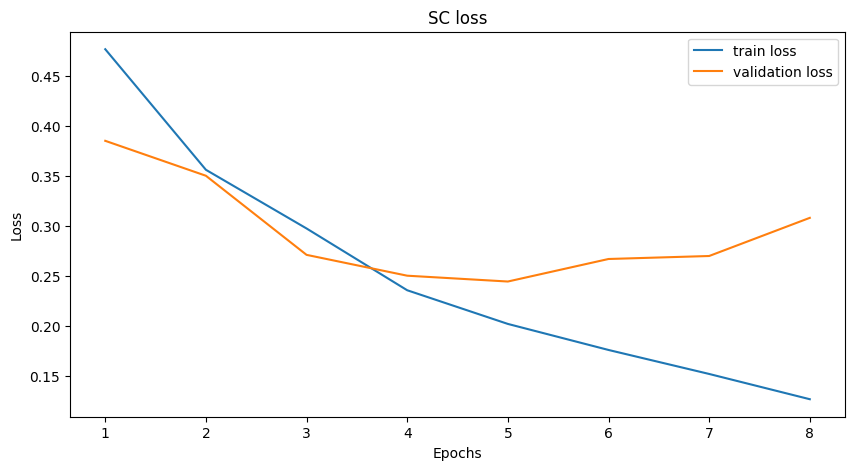

In [100]:
plt.figure(figsize=(10,5))
plt.title("SC loss" if scheme else "AC loss")
plt.plot(statistics['train_loss_values'],label="train loss")
plt.plot(statistics['val_loss_values'],label="validation loss")
plt.xlabel("Epochs")
plt.xticks(np.arange(epochs), np.arange(1, epochs+1, 1))
plt.ylabel("Loss")
plt.legend()
plt.show()

## SC Evaluation

In [101]:
def evaluate(model, data_loader, use_cuda=True):
    predictions = []
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    loop = tqdm(data_loader)
    with torch.no_grad():
        for batch in loop:
            pred = model(batch['input_ids'].to(device), attention_mask = batch["attention_mask"].to(device))
            pred = pred.cpu().detach().numpy()
            predictions.append(pred)
    predictions = np.concatenate(predictions)
    return predictions
    

In [102]:
from sklearn.metrics import classification_report,f1_score


#TRAIN = True
if scheme:
    #y_pred = base_model.predict(base_test_encodings)
    #print("\n Baseline: \n"+classification_report(df_test['Scheme'], y_pred))
    test_encodings = encode(tokenizer,df_test,test_labels,scheme)
    train_encodings = encode(tokenizer,df_train,train_labels,scheme)
    val_encodings = encode(tokenizer,df_val,val_labels,scheme)
    #create test dataset
    test_dataset = CustomTorchDataset(test_encodings)
    train_dataset = CustomTorchDataset(train_encodings)
    val_dataset = CustomTorchDataset(val_encodings)
    
    #create test dataloader
    data_loader_test = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle = False)
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                        batch_size=batch_size,
                                        shuffle = False)
    data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=batch_size,
                                        shuffle = False)
    #train_predictions = evaluate(model, data_loader_train)
    #val_predictions = evaluate(model, data_loader_val)
    test_predictions = evaluate(model, data_loader_test)


    #search for best threshold on validation set using f1 score with macro avg

#    thresholds = list(np.arange(0,0.9,0.01))
#    res = []
#    for t in thresholds:
#        if TRAIN:
#            y_pred = np.where(train_predictions<t, 0., 1.)
#            y_true = np.array(train_labels)
#        else:
#            y_pred = np.where(val_predictions<t, 0., 1.)
#            y_true = np.array(val_labels)
#        x = f1_score(y_true,y_pred,average='macro')
#        res.append(x)
#    best_idx = np.argmax(res)
#    print(f'best_threshold:{thresholds[best_idx]}')

    #compute test score
    y_pred = np.where(test_predictions<0.5, 0., 1.)
    y_true = np.array(test_labels)
    report = classification_report(y_true, y_pred,output_dict=True, target_names = sc_classes)
    print(y_true.shape,y_pred.shape)
    print(classification_report(y_true, y_pred, target_names = sc_classes))

Encoding...
input shape: (249, 410)
Encoding complete
Encoding...
input shape: (885, 391)
Encoding complete
Encoding...
input shape: (150, 351)
Encoding complete


  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 8/8 [00:03<00:00,  2.41it/s]

(249, 8) (249, 8)
              precision    recall  f1-score   support

        Rule       0.90      0.94      0.92       126
        Prec       0.97      0.92      0.95        76
        Itpr       0.55      0.58      0.56        52
       Princ       0.23      0.17      0.19        18
       Class       0.00      0.00      0.00        25
         Aut       0.57      0.67      0.62        12
        Syst       0.00      0.00      0.00         6
        Tele       0.00      0.00      0.00         4

   micro avg       0.80      0.72      0.76       319
   macro avg       0.40      0.41      0.40       319
weighted avg       0.71      0.72      0.72       319
 samples avg       0.80      0.74      0.75       319




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classi

In [103]:
f1_macro = report["macro avg"]["f1-score"]
f1_macro

0.404763404016722

## GE3(embedding augmentation)

In [104]:
df_train, df_val, df_test = split_dataset_sc(df_sc_final)
print("Scheme task")
train_labels = df_train[sc_classes]
val_labels = df_val[sc_classes]
test_labels = df_test[sc_classes]
num_labels = train_labels.shape[1]

Number of training samples: 485 (37.77258566978193%)
Number of validation examples: 93 (7.242990654205608%)
Number of test samples: 125 (9.735202492211839%)
Number of training samples: 183 (14.25233644859813%)
Number of validation examples: 32 (2.4922118380062304%)
Number of test samples: 66 (5.140186915887851%)
Number of training samples: 99 (7.710280373831775%)
Number of validation examples: 16 (1.2461059190031152%)
Number of test samples: 15 (1.1682242990654206%)
Number of training samples: 118 (9.190031152647975%)
Number of validation examples: 9 (0.7009345794392523%)
Number of test samples: 43 (3.3489096573208723%)
Scheme task


In [105]:
from sklearn.metrics import classification_report,f1_score
epochs = 1
scheme = True
model, tokenizer, statistics = execute(
    lr,
    epochs,
    batch_size,
    num_labels,
    df_train,
    train_labels,
    df_val,
    val_labels,
    scheme,
    focal=False,
    model_name=model_checkpoint,
    use_cuda=USE_CUDA,
    include_previous=False,
    sampler = None,
    cwt=None
)

Some weights of BertModel were not initialized from the model checkpoint at dlicari/Italian-Legal-BERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding...
input shape: (885, 391)
Encoding complete
Encoding...
input shape: (150, 351)
Encoding complete
ENCODING COMPLETE.
STARTING TRAINING with complete data:


  0%|          | 0/28 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
Epoch 1: 100%|██████████| 28/28 [00:36<00:00,  1.29s/it, loss=0.4]


Epoch: 1  Lr: 0.00005000  Loss: Train = [0.4751] - Val = [0.3838]  Time one epoch (s): 37.7696 
Time for 1 epochs (s): 37.770
TRAINING COMPLETE.


In [106]:
class Classifier(nn.Module):
    def __init__(self, output_size):
        super(Classifier, self).__init__()
        self.output_size = output_size
        self.cl1 = nn.Linear(768, 768)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(768, self.output_size)

    def forward(self, input):
        x = self.cl1(input)
        x = self.relu(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x

In [107]:
cls = Classifier(num_labels)
cls

Classifier(
  (cl1): Linear(in_features=768, out_features=768, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=768, out_features=8, bias=True)
)

In [108]:
sub = dict(list(model.state_dict().items())[-4:])
sub.keys()

dict_keys(['cl1.weight', 'cl1.bias', 'classifier.weight', 'classifier.bias'])

In [109]:
cls.load_state_dict(sub)

<All keys matched successfully>

In [110]:
cls(torch.zeros((5,768))).size()

torch.Size([5, 8])

In [111]:
#m,t= getModel("dlicari/Italian-Legal-BERT",num_labels,scheme = True)
m,t = model,tokenizer
train_encodings = encode(t, df_train, train_labels, scheme, include_previous=False)
tot =  len(train_encodings['input_ids'])
device = torch.device('cuda')
m.to(device)
print(tot)
b_size = 32
n_minibatch = tot //b_size
print(f"n_minibatches: {n_minibatch}")
embeddings= []
for i in range(n_minibatch):
    start = i*b_size
    end = (i+1)*b_size
    with torch.no_grad():
        input = torch.stack([torch.tensor(t,device=device) for t in train_encodings['input_ids'][start:end]])
        mask = torch.stack([torch.tensor(t,device=device) for t in train_encodings['attention_mask'][start:end]])
        #out = m(torch.tensor(train_encodings['input_ids'][start:end],device=device),torch.tensor(train_encodings['attention_mask'][start:end],device=device))
        #print(input.size())
        out = m(input,mask,only_embeddings=True)

    embeddings = embeddings + list(out)
tot = len(embeddings)
print(tot)

Encoding...
input shape: (885, 391)
Encoding complete
885
n_minibatches: 27
864


In [112]:
train_labels
for x in np.array(train_labels):
    if list(x).count(1) > 1:
        break
        #print(x)
lab = df_train['Scheme'][:tot].reset_index(drop=True)
lab

0       Rule
1       Itpr
2       Rule
3       Itpr
4       Prec
       ...  
859    Princ
860     Rule
861     Prec
862     Tele
863     Rule
Name: Scheme, Length: 864, dtype: object

In [113]:
print(torch.stack(embeddings).unsqueeze(1).size())
e = torch.stack(embeddings).detach().cpu().numpy()
def compress(x):
    return list(x)

e1 = list(map(compress, e))
np.array(e1).shape
enc_lab = np.array(train_labels[:tot])
len(enc_lab.tolist())

torch.Size([864, 1, 768])


864

In [114]:
e = torch.stack(embeddings).detach().cpu().numpy()
df = pd.DataFrame()
#df.head(10)
df['embeddings'] = e.tolist()
#df.assign(embeddings=list(e))
#df.assign(labels=lab.tolist())
df['labels'] = lab
#df['enc_labels'] = enc_lab.tolist()
#df.head(10)
df

,embeddings,labels
0,"[0.12162520736455917, -0.34163880348205566, -0...",Rule
1,"[0.1658390760421753, -0.3227277398109436, -0.9...",Itpr
2,"[0.09597893804311752, -0.3331433832645416, -0....",Rule
3,"[0.17985118925571442, -0.3123069107532501, -0....",Itpr
4,"[0.09751901030540466, -0.3189718425273895, -0....",Prec
...,...,...
859,"[0.15187722444534302, -0.3496837317943573, -0....",Princ
860,"[0.09473556280136108, -0.34491628408432007, -0...",Rule
861,"[0.1944553405046463, -0.33162540197372437, -0....",Prec
862,"[0.18034854531288147, -0.3627682328224182, -0....",Tele


In [115]:
df = clean_list(df,'labels')
df

,embeddings,labels,labels2
0,"[0.12162520736455917, -0.34163880348205566, -0...",Rule,Rule
1,"[0.1658390760421753, -0.3227277398109436, -0.9...",Itpr,Itpr
2,"[0.09597893804311752, -0.3331433832645416, -0....",Rule,Rule
3,"[0.17985118925571442, -0.3123069107532501, -0....",Itpr,Itpr
4,"[0.09751901030540466, -0.3189718425273895, -0....",Prec,Prec
...,...,...,...
859,"[0.15187722444534302, -0.3496837317943573, -0....",Princ,Princ
860,"[0.09473556280136108, -0.34491628408432007, -0...",Rule,Rule
861,"[0.1944553405046463, -0.33162540197372437, -0....",Prec,Prec
862,"[0.18034854531288147, -0.3627682328224182, -0....",Tele,Tele


In [116]:
#consider each combination of labels as a different label
names = df['labels'].explode().unique()
len(names)
names

array(['Rule', 'Itpr', 'Prec', 'Class', 'Princ', 'Aut', 'Syst', 'Tele'],
      dtype=object)

In [117]:
#mean_embeddings = np.empty((len(names),768))
df = df.explode('labels')
mean_embeddings = dict()
for name in names:
    a = df[df['labels']==name]
    #print(a['embeddings'].apply(lambda x: np.array(x)))
    q = np.array(a['embeddings'])

    #print(type(a['embeddings'].iloc[0]))
    #a.head(10)
    q =np.array(list(map(lambda x: np.array(x),q)))
    #np.array(q1).shape
    if len(q)==0:
        print(name)
    mean_embeddings[name] = q.mean(0)
    #print(np.array(a['embeddings']).shape)
len(mean_embeddings)

8

In [118]:
#create new embeddings: target_emb = source_emb - mean_source + mean_target
new_embeddings = []
new_labels = []
for source in names:
    a = df[df['labels']==source]
    print(f'source: {source}, length:{len(a)}')
    for target in names:
        l=0
        if target == source:
            continue
        for e in a['embeddings']:
            l = l + 1
            new = np.array(e) - mean_embeddings[source] + mean_embeddings[target]
            new_embeddings.append(new)
            new_labels.append(target)
        print(source,target,l)
len(new_embeddings)

source: Rule, length:372
Rule Itpr 372
Rule Prec 372
Rule Class 372
Rule Princ 372
Rule Aut 372
Rule Syst 372
Rule Tele 372
source: Itpr, length:223
Itpr Rule 223
Itpr Prec 223
Itpr Class 223
Itpr Princ 223
Itpr Aut 223
Itpr Syst 223
Itpr Tele 223
source: Prec, length:287
Prec Rule 287
Prec Itpr 287
Prec Class 287
Prec Princ 287
Prec Aut 287
Prec Syst 287
Prec Tele 287
source: Class, length:63
Class Rule 63
Class Itpr 63
Class Prec 63
Class Princ 63
Class Aut 63
Class Syst 63
Class Tele 63
source: Princ, length:92
Princ Rule 92
Princ Itpr 92
Princ Prec 92
Princ Class 92
Princ Aut 92
Princ Syst 92
Princ Tele 92
source: Aut, length:53
Aut Rule 53
Aut Itpr 53
Aut Prec 53
Aut Class 53
Aut Princ 53
Aut Syst 53
Aut Tele 53
source: Syst, length:17
Syst Rule 17
Syst Itpr 17
Syst Prec 17
Syst Class 17
Syst Princ 17
Syst Aut 17
Syst Tele 17
source: Tele, length:9
Tele Rule 9
Tele Itpr 9
Tele Prec 9
Tele Class 9
Tele Princ 9
Tele Aut 9
Tele Syst 9


7812

In [119]:
#reverse exploding
df =df.rename_axis(index='ind')
df1 = df.explode('labels').groupby(by='ind').agg({'embeddings':list,'labels':list})
df1

,embeddings,labels
ind,,
0,"[[0.12162520736455917, -0.34163880348205566, -...",[Rule]
1,"[[0.1658390760421753, -0.3227277398109436, -0....",[Itpr]
2,"[[0.09597893804311752, -0.3331433832645416, -0...",[Rule]
3,"[[0.17985118925571442, -0.3123069107532501, -0...",[Itpr]
4,"[[0.09751901030540466, -0.3189718425273895, -0...",[Prec]
...,...,...
859,"[[0.15187722444534302, -0.3496837317943573, -0...",[Princ]
860,"[[0.09473556280136108, -0.34491628408432007, -...",[Rule]
861,"[[0.1944553405046463, -0.33162540197372437, -0...",[Prec]


In [120]:
#remove list of list in embedding column
def f(x):
    return x[0]

df1['embeddings'] = df1['embeddings'].apply(f)
df1['embeddings']

ind
0      [0.12162520736455917, -0.34163880348205566, -0...
1      [0.1658390760421753, -0.3227277398109436, -0.9...
2      [0.09597893804311752, -0.3331433832645416, -0....
3      [0.17985118925571442, -0.3123069107532501, -0....
4      [0.09751901030540466, -0.3189718425273895, -0....
                             ...                        
859    [0.15187722444534302, -0.3496837317943573, -0....
860    [0.09473556280136108, -0.34491628408432007, -0...
861    [0.1944553405046463, -0.33162540197372437, -0....
862    [0.18034854531288147, -0.3627682328224182, -0....
863    [0.09112679958343506, -0.37263545393943787, -0...
Name: embeddings, Length: 864, dtype: object

In [121]:
df1

,embeddings,labels
ind,,
0,"[0.12162520736455917, -0.34163880348205566, -0...",[Rule]
1,"[0.1658390760421753, -0.3227277398109436, -0.9...",[Itpr]
2,"[0.09597893804311752, -0.3331433832645416, -0....",[Rule]
3,"[0.17985118925571442, -0.3123069107532501, -0....",[Itpr]
4,"[0.09751901030540466, -0.3189718425273895, -0....",[Prec]
...,...,...
859,"[0.15187722444534302, -0.3496837317943573, -0....",[Princ]
860,"[0.09473556280136108, -0.34491628408432007, -0...",[Rule]
861,"[0.1944553405046463, -0.33162540197372437, -0....",[Prec]


In [122]:
new_df = pd.DataFrame()
new_df['embeddings'] = new_embeddings
new_df['labels'] = new_labels
#new_df.describe()
#q = (new_df['embeddings'][:2])
#q = np.array(list(map(lambda x: np.array(x),q)))
#torch.stack(list(map(lambda x: torch.tensor(x),q))).
new_df['labels'].value_counts()

labels
Tele     1107
Syst     1099
Aut      1063
Class    1053
Princ    1024
Itpr      893
Prec      829
Rule      744
Name: count, dtype: int64

In [123]:
#merge dataframes
tot_df = pd.concat([df1,new_df],ignore_index=True)
#final_df = pd.get_dummies(tot_df,columns = ['labels'],dtype=float)

z = tot_df.explode('labels')
z['labels'].value_counts()
#convert list labels to string
tot_df=clean_list(tot_df,'labels')
tot_df

,embeddings,labels,labels2
0,"[0.12162520736455917, -0.34163880348205566, -0...",[Rule],Rule
1,"[0.1658390760421753, -0.3227277398109436, -0.9...",[Itpr],Itpr
2,"[0.09597893804311752, -0.3331433832645416, -0....",[Rule],Rule
3,"[0.17985118925571442, -0.3123069107532501, -0....",[Itpr],Itpr
4,"[0.09751901030540466, -0.3189718425273895, -0....",[Prec],Prec
...,...,...,...
8671,"[-0.2670068410073036, -0.32274358549149207, -0...",Syst,Syst
8672,"[0.20842328995125353, -0.3769378868582981, -0....",Syst,Syst
8673,"[0.14604591160671773, -0.29281677880318335, -0...",Syst,Syst
8674,"[0.13125544368879857, -0.34278812088997535, -0...",Syst,Syst


In [124]:
#apply again the multibinarizer on Scheme, before transform the list classes into str,
#and get a one hot encoding of the labels
mlb1 = MultiLabelBinarizer()

mlb_result = mlb.fit_transform([str(tot_df.loc[i,'labels2']).split(',') for i in range(len(tot_df))])

df_aug = pd.concat([tot_df,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_aug_labels = df_aug[sc_classes]
df_aug_train = df_aug['embeddings']

In [125]:
las = torch.stack(list(map(lambda l: torch.tensor(l,device=device,dtype=torch.float32),np.array(train_labels))))
las.size()

torch.Size([885, 8])

In [126]:
#preprocessing
#q = (new_df['embeddings'][:2])
#q = np.array(list(map(lambda x: np.array(x),q)))
#torch.stack(list(map(lambda x: torch.tensor(x),q)))

train_data = torch.stack(list(map(lambda e: torch.tensor(e,device=device,dtype=torch.float32),df_aug_train)))
train_labs = torch.stack(list(map(lambda l: torch.tensor(l,device=device,dtype=torch.float32),np.array(df_aug_labels))))
print(train_data.size(),train_labs.size())


torch.Size([8676, 768]) torch.Size([8676, 8])


In [127]:
#clsf = classifier(11)
cls.to(device).train()

Classifier(
  (cl1): Linear(in_features=768, out_features=768, bias=True)
  (relu): ReLU()
  (classifier): Linear(in_features=768, out_features=8, bias=True)
)

In [128]:
#define loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(cls.parameters(), lr=5e-5, weight_decay=1.5e-2)

In [129]:
b_size = 32
n_minibatch = len(train_data) //b_size
print(f"n_minibatches: {n_minibatch}")
for e in tqdm(range(3000)):
    losses= []
    for i in range(n_minibatch):
        start = i*b_size
        end = (i+1)*b_size
        optimizer.zero_grad()

        preds = cls(train_data[start:end])
        ground = train_labs[start:end]
        loss = criterion(preds,ground)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    tot_loss = np.mean(losses)
    if((e+1)%100)==0:
        print(f'epoch: {e+1}, loss:{tot_loss}')



n_minibatches: 271


  3%|▎         | 100/3000 [00:33<16:37,  2.91it/s]

epoch: 100, loss:0.3529105801204034


  7%|▋         | 200/3000 [01:07<15:54,  2.93it/s]

epoch: 200, loss:0.31445656623347656


 10%|█         | 300/3000 [01:40<15:11,  2.96it/s]

epoch: 300, loss:0.29249453250442486


 13%|█▎        | 400/3000 [02:14<14:36,  2.97it/s]

epoch: 400, loss:0.2780738504417928


 17%|█▋        | 500/3000 [02:48<14:23,  2.89it/s]

epoch: 500, loss:0.2680370873493242


 20%|██        | 600/3000 [03:21<13:12,  3.03it/s]

epoch: 600, loss:0.25989071225465665


 23%|██▎       | 700/3000 [03:55<12:51,  2.98it/s]

epoch: 700, loss:0.25228984010615474


 27%|██▋       | 800/3000 [04:28<12:23,  2.96it/s]

epoch: 800, loss:0.2454073537635957


 30%|███       | 900/3000 [05:02<11:42,  2.99it/s]

epoch: 900, loss:0.2396014245515655


 33%|███▎      | 1000/3000 [05:35<11:16,  2.96it/s]

epoch: 1000, loss:0.2344188505983001


 37%|███▋      | 1100/3000 [06:09<10:42,  2.96it/s]

epoch: 1100, loss:0.22972192800847807


 40%|████      | 1200/3000 [06:43<10:03,  2.98it/s]

epoch: 1200, loss:0.22582072586790278


 43%|████▎     | 1300/3000 [07:16<09:29,  2.98it/s]

epoch: 1300, loss:0.22215290768999896


 47%|████▋     | 1400/3000 [07:50<09:12,  2.89it/s]

epoch: 1400, loss:0.21894432756383095


 50%|█████     | 1500/3000 [08:23<08:14,  3.03it/s]

epoch: 1500, loss:0.21587803647458223


 53%|█████▎    | 1600/3000 [08:57<07:46,  3.00it/s]

epoch: 1600, loss:0.21322971800294088


 57%|█████▋    | 1700/3000 [09:31<07:26,  2.91it/s]

epoch: 1700, loss:0.21059070978952896


 60%|██████    | 1800/3000 [10:05<06:48,  2.94it/s]

epoch: 1800, loss:0.20838131529117532


 63%|██████▎   | 1900/3000 [10:38<06:17,  2.91it/s]

epoch: 1900, loss:0.20620250818405533


 67%|██████▋   | 2000/3000 [11:12<05:34,  2.99it/s]

epoch: 2000, loss:0.20394163645590857


 70%|███████   | 2100/3000 [11:46<05:00,  3.00it/s]

epoch: 2100, loss:0.2021956411894837


 73%|███████▎  | 2200/3000 [12:19<04:33,  2.92it/s]

epoch: 2200, loss:0.20028612811059943


 77%|███████▋  | 2300/3000 [12:53<03:58,  2.93it/s]

epoch: 2300, loss:0.19828896015037084


 80%|████████  | 2400/3000 [13:27<03:24,  2.93it/s]

epoch: 2400, loss:0.19712460786447863


 83%|████████▎ | 2500/3000 [14:01<02:48,  2.96it/s]

epoch: 2500, loss:0.1957292504998687


 87%|████████▋ | 2600/3000 [14:35<02:10,  3.06it/s]

epoch: 2600, loss:0.19397013080890577


 90%|█████████ | 2700/3000 [15:08<01:40,  2.99it/s]

epoch: 2700, loss:0.19255927106283083


 93%|█████████▎| 2800/3000 [15:42<01:06,  3.02it/s]

epoch: 2800, loss:0.19134406926457484


 97%|█████████▋| 2900/3000 [16:15<00:33,  3.00it/s]

epoch: 2900, loss:0.1903276187058442


100%|██████████| 3000/3000 [16:49<00:00,  2.97it/s]

epoch: 3000, loss:0.1891514927138509


In [130]:
new_dict = model.state_dict()
for k,v in cls.state_dict().items():
    new_dict[k] = v
model.load_state_dict(new_dict)

<All keys matched successfully>

In [131]:
cls.cl1.weight

Parameter containing:
tensor([[ 0.0028,  0.0055, -0.0100,  ...,  0.0187,  0.0022,  0.0027],
        [ 0.0051, -0.0142, -0.0180,  ...,  0.0038,  0.0065,  0.0125],
        [ 0.0071, -0.0112,  0.0040,  ...,  0.0169, -0.0154,  0.0054],
        ...,
        [ 0.0039, -0.0100,  0.0113,  ..., -0.0139,  0.0122, -0.0108],
        [ 0.0176,  0.0124,  0.0071,  ..., -0.0004,  0.0119, -0.0008],
        [-0.0080,  0.0153,  0.0179,  ..., -0.0166,  0.0090,  0.0100]],
       device='cuda:0', requires_grad=True)

In [132]:
model.cl1.weight

Parameter containing:
tensor([[ 0.0028,  0.0055, -0.0100,  ...,  0.0187,  0.0022,  0.0027],
        [ 0.0051, -0.0142, -0.0180,  ...,  0.0038,  0.0065,  0.0125],
        [ 0.0071, -0.0112,  0.0040,  ...,  0.0169, -0.0154,  0.0054],
        ...,
        [ 0.0039, -0.0100,  0.0113,  ..., -0.0139,  0.0122, -0.0108],
        [ 0.0176,  0.0124,  0.0071,  ..., -0.0004,  0.0119, -0.0008],
        [-0.0080,  0.0153,  0.0179,  ..., -0.0166,  0.0090,  0.0100]],
       device='cuda:0', requires_grad=True)

In [133]:
from sklearn.metrics import classification_report,f1_score


TRAIN = False
if scheme:

    #y_pred = base_model.predict(base_test_encodings)

    #print("\n Baseline: \n"+classification_report(df_test['Scheme'], y_pred))

    if TRAIN:
        train_encodings = encode(tokenizer,df_train,train_labels,scheme,include_previous=INCLUDE_PREVIOUS)
        train_dataset = CustomTorchDataset(train_encodings)
    else:
        test_encodings = encode(tokenizer,df_test,test_labels,scheme,include_previous=INCLUDE_PREVIOUS)
        test_dataset = CustomTorchDataset(test_encodings)


    #create test dataloader

    data_loader_test = torch.utils.data.DataLoader(test_dataset,

                                        batch_size=batch_size,

                                        shuffle = False)
    if TRAIN:
        data_loader_train = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle = False)
        train_predictions = evaluate(model, data_loader_train)
    
    test_predictions = evaluate(model, data_loader_test)
    if TRAIN:
        y_pred = np.where(train_predictions<0.5, 0., 1.)
        y_true = np.array(train_labels)
    else:
        y_pred = np.where(test_predictions<0.5, 0., 1.)
        y_true = np.array(test_labels)


    #print(y_pred)


    print(y_true.shape,y_pred.shape)
    print("\n"+classification_report(y_true, y_pred,target_names = sc_classes))

Encoding...
input shape: (249, 410)
Encoding complete


  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_24/537690395.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
100%|██████████| 8/8 [00:03<00:00,  2.44it/s]

(249, 8) (249, 8)

              precision    recall  f1-score   support

        Rule       0.93      0.21      0.35       126
        Prec       1.00      0.32      0.48        76
        Itpr       0.62      0.10      0.17        52
       Princ       0.23      0.17      0.19        18
       Class       0.11      0.04      0.06        25
         Aut       0.18      0.17      0.17        12
        Syst       0.40      0.33      0.36         6
        Tele       0.00      0.00      0.00         4

   micro avg       0.65      0.20      0.31       319
   macro avg       0.43      0.17      0.22       319
weighted avg       0.74      0.20      0.31       319
 samples avg       0.24      0.23      0.23       319




/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
